# Deep painterly harmonization

This notebook is an implementation of the article [Deep Painterly Harmonization](https://arxiv.org/abs/1804.03189). It runs on top of the fastai library although it doesn't use many features from it apart to load the images and normalize them in the way the model (VGG16) expects it, so it's easy to convert it in full pytorch.

The authors of the article provided their code (in torch) [here](https://github.com/luanfujun/deep-painterly-harmonization) and I've used it to get an idea on how they implemented certain parameters that aren't very well explained in the paper. There are also a few instances where the code and the article directly contradict each other. In those cases, I've followed the code, but I'll put some warnings so you know what I'm talking about.

Lastly, there is one feature described in the second stage of their algorithm that I haven't understood, and when I tried to replicate the corresponding code, it gave awful results. Since I got the same kind of final results as the ones they showed, I decided to ignore it. Again, I'll explain what it is when we get there.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *

You can download the data they used for their article [here](https://github.com/luanfujun/deep-painterly-harmonization). Be sure to make the PATH variable point to it.

In [3]:
PATH = Path('../data/paintings')

We will focus on example 4 for this notebook. Each example has four pictures associated to it: the input (our objet superposed on the painting), the style image (which is the painting), the mask that allows us to know where we added the object and a dilated version of it.

In [4]:
idx = 16
input_img = open_image(PATH/f'{idx}_naive.jpg')
style_img = open_image(PATH/f'{idx}_target.jpg')
mask = open_image(PATH/f'{idx}_c_mask.jpg')
loose_mask = open_image(PATH/f'{idx}_c_mask_dilated.jpg')

Let's draw this.

(-0.5, 699.5, 556.5, -0.5)

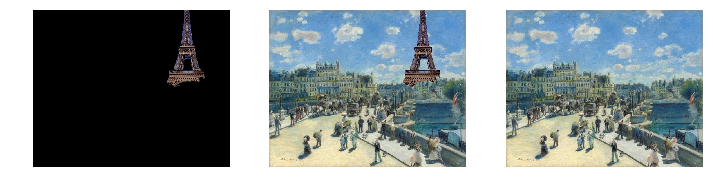

In [5]:
fig, axs = plt.subplots(1,3,figsize = (12,6))
axs[0].imshow(input_img * mask)
axs[0].axis('off')
axs[1].imshow(input_img)
axs[1].axis('off')
axs[2].imshow(style_img)
axs[2].axis('off')


The loose mask is just a bit wider as the regular mask.

(-0.5, 699.5, 556.5, -0.5)

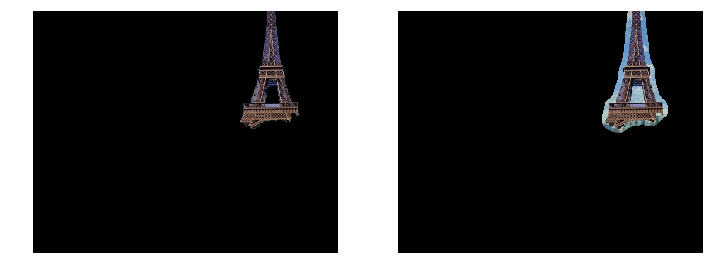

In [6]:
fig, axs = plt.subplots(1,2,figsize = (12,6))
axs[0].imshow(input_img * mask)
axs[0].axis('off')
axs[1].imshow(input_img * loose_mask)
axs[1].axis('off')

The authors of the article proved the function they used to dilate a given mask. If you want to run your own examples, here it is. The gaussian blur will smoothly enlarge it, and then we only keep the pixel values greater than 0.1.

In [7]:
def dilate_mask(mask):
    loose_mask = cv2.GaussianBlur(mask, (35,35) , 35/3)
    loose_mask[loose_mask>=0.1] = 1
    return loose_mask

Let's check it works properly here.

In [8]:
loose_mask1 = dilate_mask(mask)

(-0.5, 699.5, 556.5, -0.5)

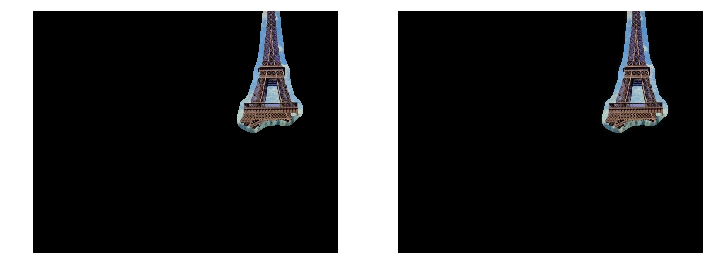

In [9]:
fig, axs = plt.subplots(1,2,figsize = (12,6))
axs[0].imshow(input_img * loose_mask)
axs[0].axis('off')
axs[1].imshow(input_img * loose_mask1)
axs[1].axis('off')

They look the same indeed! Lastly we create a slightly enlarged version of our tight mask that we will use in the end to reconstruct the output.

In [10]:
mask_smth = cv2.GaussianBlur(mask, (3,3) , 1)

We get the transforms from the vgg model, to have the right parameters for Normalization (since I'm lazy).

In [11]:
trn_tfms, val_tfms = tfms_from_model(vgg16, 500, crop_type=CropType.NO)

This bit removes the resize transform since we want to keep the image at their specific size.

In [12]:
val_tfms.tfms = val_tfms.tfms[2:]

In [13]:
val_tfms

[<fastai.transforms.Normalize object at 0x7ff8acffafd0>, <fastai.transforms.ChannelOrder object at 0x7ff8ad0c2e10>]

If you don't have a lot of RAM on your GPU, you may want to uncomment this to halves the dimensions of the images. Result won't be as nice, but you'll get the idea.

In [14]:
#def halve_size(mask):
#    h,w = mask.shape[:2]
#    return cv2.resize(mask, (w//2,h//2))
#input_img = halve_size(input_img)
#style_img = halve_size(style_img)
#mask = halve_size(mask)
#loose_mask = halve_size(loose_mask)
#mask_smth = halve_size(mask_smth)

Then we can get our pictures ready for the model.

In [15]:
input_tfm = val_tfms(input_img)
style_tfm = val_tfms(style_img)

# Model

The authors of the article used VGG19 but I didn't see any difference by using VGG16 (the version with BatchNorm), so since it's lighter and a bit faster, we'll use this one. You can switch back to VGG19 by replacing the 16 here, then be careful with layer numbers (I've provided the correct ones if you decide to change).

In the two steps of the algorithm, we will only use the results of the layer 36 max (42 in VGG19), so I've discarded the ones we don't use for memory purposes.

In [16]:
layers = cut_model(vgg16(True),37) #43 vor VGG19
m_vgg = to_gpu(nn.Sequential(*layers)).eval()
set_trainable(m_vgg, False)

In [17]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

We will use the results of conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1 during the two steps of the process. It corresponds to the result of the first ReLU we can see at the beginning (for conv1) and after each MaxPool (for the others) so the indexes are 2, 9, 16, 26 and 36 (2, 9, 16, 29 and 42 for VGG19).

In [18]:
m_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

# First pass

The first pass only uses conv3_1, conv4_1 and conv5_1.

In [19]:
idx_layers = [16,26,36] #[16, 29, 42] for VGG19

Let's hook those specific layers so that when we get one thing through the model, it saves their results.

In [20]:
class SaveFeatures(nn.Module):
    features = None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [21]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in idx_layers]

Now we can grab the features for our image input and our style image. The [None] is to had a batch dimension and the VV command is short for Variable without require_grad, so that pytorch is happy.

In [22]:
m_vgg(VV(input_tfm[None]))
input_ftrs = [s.features for s in sfs]
[sf.shape for sf in input_ftrs]

[torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87]),
 torch.Size([1, 512, 34, 43])]

In [23]:
m_vgg(VV(style_tfm[None]))
style_ftrs = [s.features for s in sfs]
[sf.shape for sf in style_ftrs]

[torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87]),
 torch.Size([1, 512, 34, 43])]

The next thing we need is to make a pass with our mask to have its corresponding features. The authors say in the article they resize it, but in the code, they half its dimension at each max pooling, then pass it through a 3 by 3 stride 1 padding 1 average pooling at each convolutional layer, so let's do that.

In [24]:
def halve_size(mask):
    h,w = mask.shape
    return cv2.resize(mask, (w//2,h//2)) 

In [25]:
ConvolMask = nn.AvgPool2d(3, 1, 1)
def convol(mask, nb):
    x = V(mask[None][None])
    for i in range(nb): x = ConvolMask(x)
    return to_np(x.data.squeeze())

In [26]:
def get_mask_ftrs(mask):
    ftrs = []
    mask = halve_size(convol(mask,2))
    mask = halve_size(convol(mask,2))
    mask = convol(mask,1)
    ftrs.append(mask)
    mask = halve_size(convol(mask,2))#3 for VGG19
    mask = convol(mask,1)
    ftrs.append(mask)
    mask = halve_size(convol(mask,2))#3 for VGG19
    mask = convol(mask,1)
    ftrs.append(mask)
    return ftrs

In [27]:
mask_ftrs = get_mask_ftrs(loose_mask[:,:,0])
[mf.shape for mf in mask_ftrs]

[(139, 175), (69, 87), (34, 43)]

Note that the shapes of our input features, style features, mask features are all the same for each layer.

## Mapping

The first pass is based on a content loss and a style loss as is usual in style transfer, but first, we have to map every pixel of the content features to one in the style features. To determine the mapping, we look at every 3 by 3 window of the style features, that we flatten into a vector of size 9 * channels. We will then map a pixel in the content to the one in the style that is at the center of the patch nearest to the 3 by 3 patch around the pixel. 

To do this fast, we use this function to get all the possible patches in a big array that we'll throw on the CPU. This program is very much like the one I used to code a convolutional layer from scratch in numpy [in this blog post](https://sgugger.github.io/convolution-in-depth.html#convolution-in-depth).

Basically we had a padding of zeros (to have a 3 by 3 window everywhere), the start indexes correspond to all the top-left corners of the windows, and the grid gives the indexes of all the 3 by 3 by channel window.

In [28]:
def get_patches(x,ks=3,stride=1,padding=1):
    ch, n1, n2 = x.shape
    y = np.zeros((ch,n1+2*padding,n2+2*padding))
    y[:,padding:n1+padding,padding:n2+padding] = x
    start_idx = np.array([j + (n2+2*padding)*i for i in range(0,n1-ks+1+2*padding,stride) for j in range(0,n2-ks+1+2*padding,stride) ])
    grid = np.array([j + (n2+2*padding)*i + (n1+2*padding) * (n2+2*padding) * k for k in range(0,ch) for i in range(ks) for j in range(ks)])
    to_take = start_idx[:,None] + grid[None,:]
    return y.take(to_take)

Then we can compute all the cosine similarities very easily and get the mapping. VV puts all on the GPU if there's one available so that this goes fast.

In [29]:
def match_ftrs(inp_ftrs,sty_ftrs):
    res = []
    for l_inp,s_inp in zip(inp_ftrs,sty_ftrs):
        l_inp = VV(get_patches(to_np(l_inp[0].data)))
        s_inp = VV(get_patches(to_np(s_inp[0].data)))
        scals = torch.mm(l_inp,s_inp.t())
        norms_in = torch.sqrt((l_inp ** 2).sum(1))
        norms_st = torch.sqrt((s_inp ** 2).sum(1))
        cosine_sim = scals / (1e-15 + norms_in.unsqueeze(1) * norms_st.unsqueeze(0))
        _, idx_max = cosine_sim.max(1)
        res.append(to_np(idx_max))
    return res

In [30]:
map_ftrs = match_ftrs(input_ftrs, style_ftrs)

Then we use this map to transform the style features.

In [31]:
def map_style():
    res = []
    for sf, mapf in zip(style_ftrs, map_ftrs):
        sf = to_np(sf).reshape(sf.size(1),-1)
        sf = sf[:,mapf]
        res.append(VV(sf))
    return res

In [32]:
sty_ftrs = map_style()

# Reconstruction

At first, our input is the content picture.

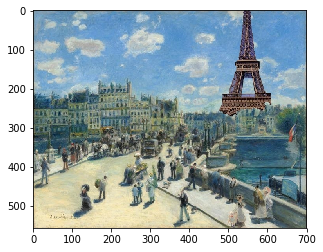

In [33]:
opt_img = input_tfm.copy()
plt.imshow(val_tfms.denorm(to_np(opt_img).transpose(1,2,0)));

We put it in a variable that will require grad.

In [34]:
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 557, 700])

This is the generic optimizer and the step function for the training.

In [35]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=1)

In [36]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter += 1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

Our content loss is just the MSE loss of the content and input features from the 4th convolutional layers (stored at index 1). We apply the corresponding mask to both of them before taking this loss. 

Note that in the MSE loss, instead of dividing by the number of activations times the number of channels, we use the number of selected activations (inside the mask) times the number of channels

In [37]:
def content_loss(out_ftrs):
    msk_of = out_ftrs * V(mask_ftrs[1][None,None], requires_grad=False)
    msk_if = input_ftrs[1] * V(mask_ftrs[1][None,None], requires_grad=False)
    return F.mse_loss(msk_of,msk_if, size_average=False) / float(out_ftrs.size(1) * mask_ftrs[1].sum())

For the syle loss, we compute the gram matrix and the MSE loss of two gram matrices.

In [38]:
def gram(input):
    x = input
    return torch.mm(x, x.t())

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

Then we apply the mask before taking this loss, for all the layers (conv 3, 4 and 5), with the input features and the remapped style features.

In [39]:
def style_loss(out_ftrs):
    loss = 0
    for of, sf, mf in zip(out_ftrs, sty_ftrs, mask_ftrs):
        to_pass = of * V(mf[None,None], requires_grad=False)
        to_pass = to_pass.view(to_pass.size(1),-1)
        sf = sf * V(mf, requires_grad=False).view(1,-1)
        loss += gram_mse_loss(to_pass,sf)
    return loss / 3

Thos are the weights for stage 1.

In [40]:
w_c, w_s = 1, 10

In [41]:
def stage1_loss(opt_img_v):
    m_vgg(opt_img_v)
    out_ftrs = [o.features for o in sfs]
    c_loss = content_loss(out_ftrs[1])
    s_loss = style_loss(out_ftrs)
    return w_c * c_loss + w_s * s_loss

Let's launch the training.

In [42]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,stage1_loss))

Iteration: 100, loss: 1.071435570716858
Iteration: 200, loss: 0.6738872528076172
Iteration: 300, loss: 0.5438193082809448
Iteration: 400, loss: 0.4766045808792114
Iteration: 500, loss: 0.4371315836906433
Iteration: 600, loss: 0.41064155101776123
Iteration: 700, loss: 0.39184218645095825
Iteration: 800, loss: 0.37797218561172485
Iteration: 900, loss: 0.36782580614089966
Iteration: 1000, loss: 0.35957789421081543


And here are the results.

(-0.5, 699.5, 556.5, -0.5)

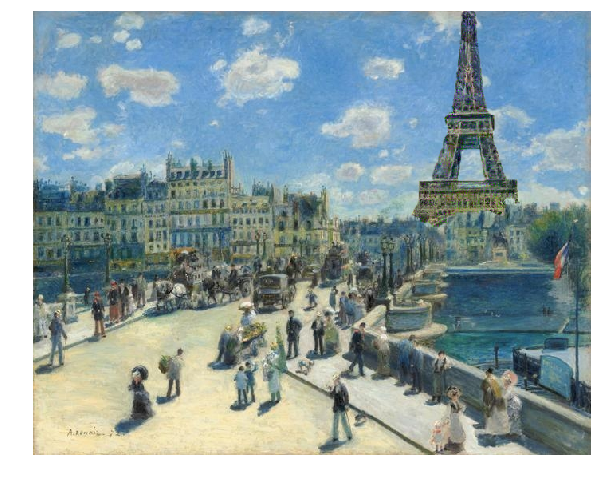

In [43]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
out_img = val_tfms.denorm(to_np(opt_img_v.data)[0].transpose(1,2,0))
out_img = out_img * mask_smth + style_img * (1-mask_smth)
out_img = out_img.clip(0, 1) #Pixel values shouldn't get below 0 or be greater than 1.
ax.imshow(out_img)
ax.axis('off')

Let's save the numpy array for the second stage, plus save the picture we obtained for references.

In [44]:
np.save(PATH/f'{idx}_stage1.npy', out_img)

# Phase 2

We begin by loading the input from the previous result.

In [45]:
stage1_img = np.load(PATH/f'{idx}_stage1.npy')
stage1_tfm = val_tfms(stage1_img)

For this part, our reference layers are conv1_1, conv_2_1, conv3_1 and conv4_1. Those are the results of layers 2, 9, 16 and 26 (after looking at the summary).

In [46]:
idx_layers = [2, 9, 16,26] #[2,9,16,29] for VGG19

In [47]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in idx_layers]

The features of the original input image will be used for the content loss.

In [48]:
m_vgg(VV(input_tfm[None]))
input_ftrs = [s.features for s in sfs]
[sf.shape for sf in input_ftrs]

[torch.Size([1, 64, 557, 700]),
 torch.Size([1, 128, 278, 350]),
 torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87])]

The features of the stage 1 image will be used for the matching in the style loss.

In [49]:
m_vgg(VV(stage1_tfm[None]))
stage1_ftrs = [s.features for s in sfs]
[sf.shape for sf in stage1_ftrs]

[torch.Size([1, 64, 557, 700]),
 torch.Size([1, 128, 278, 350]),
 torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87])]

The features of the style image will be used in the style and histogram loss.

In [50]:
m_vgg(VV(style_tfm[None]))
style_ftrs = [s.features for s in sfs]
[sf.shape for sf in style_ftrs]

[torch.Size([1, 64, 557, 700]),
 torch.Size([1, 128, 278, 350]),
 torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87])]

As before, we let the mask *run* through the network.

In [51]:
def get_mask_ftrs_st2(mask):
    ftrs = []
    mask = convol(mask,1)
    ftrs.append(mask)
    mask = halve_size(convol(mask,1))
    mask = convol(mask,1)
    ftrs.append(mask)
    mask = halve_size(convol(mask,1))
    mask = convol(mask,1)
    ftrs.append(mask)
    mask = halve_size(convol(mask,2))#3 for VGG19
    mask = convol(mask,1)
    ftrs.append(mask)
    return ftrs

In [52]:
mask_ftrs = get_mask_ftrs_st2(loose_mask[:,:,0])
[mf.shape for mf in mask_ftrs]

[(557, 700), (278, 350), (139, 175), (69, 87)]

The first matching is the same as in stage 1. 

Note that in their code, the authors normalized the style features and the stage 1 features (in the sense that they divided them by their norm). I didn't find this helpful and it led to several problems since the output features aren't normalized at the end but you can always try it. If you do, there is no need to divide by the norms here. 

In [53]:
def match_ftrs_st2(inp_ftrs,sty_ftrs):
    l_inp = VV(get_patches(to_np(inp_ftrs[0].data)))
    s_inp = VV(get_patches(to_np(sty_ftrs[0].data)))
    scals = torch.mm(l_inp,s_inp.t())
    norms_in = torch.sqrt((l_inp ** 2).sum(1))
    norms_st = torch.sqrt((s_inp ** 2).sum(1))
    cosine_sim = scals / (1e-15 + norms_in.unsqueeze(1) * norms_st.unsqueeze(0))
    _, idx_max = cosine_sim.max(1)
    return to_np(idx_max)

In [54]:
first_map = match_ftrs_st2(stage1_ftrs[-1], style_ftrs[-1])

In [55]:
first_map.shape

(6003,)

n_size is the size of the window we will look at for the neighbors (5 comes from the authors' code). 

In [56]:
n_size = 5
n_rad = n_size//2
neighbors = [np.array([i,j]) for i in range(-n_rad,n_rad+1) for j in range(-n_rad,n_rad+1)]

Just a helper function that takes an index and returns the index of the nieghbor specified in ngb.

In [57]:
def apply_neighbor(idx, ngb, size):
    n1,n2 = size
    coords = np.array([idx//n2,idx%n2]) + ngb
    if coords[0] >= 0 and coords[0] < n1 and coords[1] >= 0 and coords[1] < n2:
        return coords[0] * n2 + coords[1]
    else: return -1

Second map. Note that the code (of the authors) doesn't match the original article, I've indicated where in comments.

In [58]:
def second_match(init_map, sty_ftrs, mask, ks = 5):
    ch, n1, n2 = sty_ftrs.shape
    rad = (ks-1)//2
    sty_ftrs = np.reshape(sty_ftrs, (ch,n1*n2)).transpose()
    result = init_map.copy()
    for i in range(n1*n2):
        if mask[i] <= 0.1: continue
        candidates = []
        style_neighbors = []
        for ngb in neighbors:
            i1 = apply_neighbor(i, ngb, (n1,n2))
            if i1 != -1:
                #style_neighbors.append(init_map[i1])#Original article
                j = apply_neighbor(init_map[i1], -ngb, (n1,n2))
                if j != -1: 
                    candidates.append(j)
                    style_neighbors.append(j)#Their code
        candidates = list(set(candidates)) #Get rid of the repetitions in the candidates to speed up a bit.
        if len(candidates) <= 1:
            if len(candidates) == 0:
                pdb.set_trace()
            if candidates[0] != i:
                pdb.set_trace()
            continue
        cand_ftrs = np.take(sty_ftrs, candidates, axis=0)
        ngbr_ftrs = np.take(sty_ftrs, style_neighbors, axis=0)
        dists = ((cand_ftrs[:,None] - ngbr_ftrs[None,:]) ** 2).sum(axis=2).sum(axis=1)
        result[i] = candidates[dists.argmin()]
    return result

In the article they state that they use the features from the reference layer for this second mapping, but in their code, they use the actual style picture resized.

In [59]:
#t_mask = cv2.resize(mask, (style_ftrs[-1].size(3), style_ftrs[-1].size(2)), interpolation=cv2.INTER_NEAREST)[:,:,0]
#second_map = second_match(first_map, to_np(style_ftrs[-1][0].data), t_mask) #original article

In [60]:
style_rsz = cv2.resize(style_img,(style_ftrs[-1].size(3), style_ftrs[-1].size(2)))
t_mask = cv2.resize(mask, (style_ftrs[-1].size(3), style_ftrs[-1].size(2)), interpolation=cv2.INTER_NEAREST)[:,:,0]
style_rs_tfm, _ = val_tfms(style_rsz,mask)
second_map = second_match(first_map, style_rs_tfm, t_mask.reshape(-1)) #their code

Then we adapt the mapping to the other layers.

In [61]:
def upsample(ref_map, ref_size, new_size):
    r_h, r_w = ref_size
    n_h, n_w = new_size
    new_map = np.zeros(n_h * n_w).astype(np.int32)
    ratio_h, ratio_w = n_h/r_h, n_w/r_w
    for i in range(n_h * n_w):
        n_x, n_y = i//n_w, i%n_w
        r_x, r_y = int((0.5+n_x) / ratio_h), int((0.5+n_y)/ratio_w)
        r_x, r_y = min(max(0,r_x),r_h-1), min(max(0,r_y),r_w-1)
        style_idx = ref_map[r_x * r_w + r_y]
        s_x = int(n_x + (style_idx//r_w - r_x) * ratio_h + 0.5)
        s_y = int(n_y + (style_idx%r_w - r_y) * ratio_w + 0.5)
        s_x, s_y = min(max(0,s_x),n_h-1), min(max(0,s_y),n_w-1)
        new_map[i] = s_x * n_w + s_y
    return new_map

In [62]:
map_ftrs = [upsample(second_map, mask_ftrs[-1].shape, mf.shape) for mf in mask_ftrs[:-1]] + [second_map]

Note that we also resize the tight mask to all the other layers because this is the one that will be used on the style features for the style loss and the histogramm loss (their code). The loose mask will also be used on the output features, and for the content loss.

In [63]:
tmask_ftrs = [t_mask]
for sf in style_ftrs[-2::-1]:
    rsz_mask = cv2.resize(tmask_ftrs[0], (sf.size(3), sf.size(2)), interpolation=cv2.INTER_NEAREST)
    tmask_ftrs.insert(0,rsz_mask)
[tmf.shape for tmf in tmask_ftrs]

[(557, 700), (278, 350), (139, 175), (69, 87)]

Now let's remove the duplicates in the style features that are selected. This function still remaps the style but also returns a mask that will cover the repetitions with a 0.

In [64]:
def map_style_stg2():
    res = []
    msks = []
    for sf, mapf, mf in zip(style_ftrs, map_ftrs, tmask_ftrs):
        sf = to_np(sf).reshape(sf.size(1),-1)
        msk = mf.copy().reshape(-1)
        sf = sf[:,mapf]
        cnt = Counter(mapf)
        for i,m in enumerate(mapf):
            if msk[i] >= 0.1 and cnt[m] > 1:
                mask = (mapf == m)
                mask[i] = False
                msk[mask] = 0
        res.append(VV(sf))
        msks.append(msk)
    return res, msks

In [65]:
sty_ftrs, tmask_ftrs = map_style_stg2()

Now we can compute the histogram of the style features covered by its mask.

In [66]:
def hist_mask(sf, mf):
    res = []
    mask = torch.Tensor(mf).contiguous()
    masked = sf * mask
    return torch.cat([torch.histc(masked[i][mask>=0.1], n_bins).unsqueeze(0) for i in range(masked.size(0))]).cuda()

In [67]:
n_bins = 256
sty_flattened = [sty_ftrs[0].data.cpu(),sty_ftrs[3].data.cpu()]#Hist_c only works on the cpu, not the gpu.
mask_hist = [tmask_ftrs[0],tmask_ftrs[3]]
sty_hist = [hist_mask(sf,mf) for sf, mf in zip(sty_flattened, mask_hist)]

In [68]:
sty_hist[-1].size()

torch.Size([512, 256])

Content loss is the same as before, except that the desired features are now at the index -1.

In [69]:
def content_loss(out_ftrs):
    msk_of = out_ftrs * V(mask_ftrs[-1][None,None], requires_grad=False)
    msk_if = input_ftrs[-1] * V(mask_ftrs[-1][None,None], requires_grad=False)
    return F.mse_loss(msk_of,msk_if, size_average=False) / float(out_ftrs.size(1) * mask_ftrs[-1].sum())

Gram matrices as before.

In [70]:
def gram(input):
    x = input
    return torch.mm(x, x.t())

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

Style loss: the style features are multiplied by the tight mask (which gets rid of the repetitions if wanted) and the output is multiplied byt the loose mask. Since the masks don't have the same number of elements we have to normalize sf, the sqrt is there because the gram matrix is composed of products of elements of sf. Without this, results are compeltely random (just try for the fun of it).

In [71]:
def style_loss(out_ftrs):
    loss = 0
    for of, sf, mf, tmf in zip(out_ftrs, sty_ftrs, mask_ftrs, tmask_ftrs):
        to_pass = of * V(mf[None,None], requires_grad=False) 
        to_pass = to_pass.view(to_pass.size(1),-1)
        sf = sf * V(tmf[None], requires_grad=False).view(1,-1)
        sf = sf * float(np.sqrt(mf.sum()/tmf.sum())) #Normalize the two masks.
        loss += gram_mse_loss(to_pass,sf)
    return loss / 4

Compute the new_x that has the same histogram as hist_ref from x. The code is explained in the blog post. The first function is there to help select an array of indexes in a tensor (since torch doesn't like indexing with a multiple-dimension tensor). 

In [72]:
def select_idx(tensor, idx):
    ch = tensor.size(0)
    return tensor.view(-1)[idx.view(-1)].view(ch,-1)

In [73]:
def remap_hist(x,hist_ref):
    ch, n = x.size()
    sorted_x, sort_idx = x.data.sort(1)
    ymin, ymax = x.data.min(1)[0].unsqueeze(1), x.data.max(1)[0].unsqueeze(1)
    hist = hist_ref * n/hist_ref.sum(1).unsqueeze(1)#Normalization between the different lengths of masks.
    cum_ref = hist.cumsum(1)
    cum_prev = torch.cat([torch.zeros(ch,1).cuda(), cum_ref[:,:-1]],1)
    step = (ymax-ymin)/n_bins
    rng = torch.arange(1,n+1).unsqueeze(0).cuda()
    idx = (cum_ref.unsqueeze(1) - rng.unsqueeze(2) < 0).sum(2).long()
    ratio = (rng - select_idx(cum_prev,idx)) / (1e-8 + select_idx(hist,idx))
    ratio = ratio.squeeze().clamp(0,1)
    new_x = ymin + (ratio + idx.float()) * step
    new_x[:,-1] = ymax
    _, remap = sort_idx.sort()
    new_x = select_idx(new_x,idx)
    return new_x

Then we can compute the histogram loss.

In [74]:
def hist_loss(out_ftrs):
    loss = 0
    msk_hist = [mask_ftrs[0], mask_ftrs[3]]
    for of, mf, sh in zip(out_ftrs, msk_hist, sty_hist):
        of = of.view(of.size(1),-1)
        mask = V(torch.Tensor(mf).contiguous().view(1, -1), requires_grad=False)
        of_masked = of * mask
        of_masked = torch.cat([of_masked[i][mask>=0.1].unsqueeze(0) for i in range(of_masked.size(0))])
        loss += F.mse_loss(of_masked, V(remap_hist(of_masked, sh), requires_grad=False)) 
    return loss / 2

Finally the TV loss.

In [75]:
def tv_loss(out):
    return ((out[:,:-1,:] - out[:,1:,:]) ** 2).sum() + ((out[:,:,:-1] - out[:,:,1:]) ** 2).sum()

This is to get the parameter used in computing the weight of the TV loss.

In [76]:
def get_med_tv(arr):
    ch, h, w = arr.shape
    arr1 = np.concatenate([np.zeros((ch,w))[:,None,:], arr], axis=1)
    arr2 = np.concatenate([np.zeros((ch,h))[:,:,None], arr], axis=2)
    return np.median((arr1[:,:-1,:] - arr1[:,1:,:]) ** 2 + (arr2[:,:,:-1] - arr2[:,:,1:]) ** 2)

In [77]:
mtv = get_med_tv(style_tfm)

The formulas to compute the weight come from their code, and the parameters tau from the text file in the data folder.

In [78]:
w_s = 0.01
w_tv = float(10 / (1 + np.exp(mtv * 10**4 -25)))
w_h = 1

We can finally compute the stage 2 loss.

In [79]:
def final_loss(opt_img_v):
    m_vgg(opt_img_v)
    out_ftrs = [o.features for o in sfs]
    c_loss = content_loss(out_ftrs[-1])
    s_loss = style_loss(out_ftrs)
    h_loss = hist_loss([out_ftrs[0], out_ftrs[3]])
    t_loss = tv_loss(opt_img_v[0])
    return c_loss + w_s * s_loss + w_h * h_loss + w_tv * t_loss

The input here is the output of the previous pass.

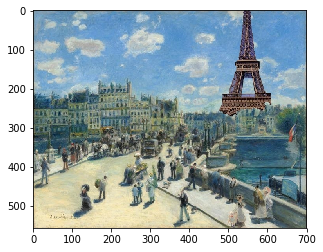

In [80]:
stage1_img = np.load(PATH/f'{idx}_stage1.npy')
stage1_tfm,_  = val_tfms(stage1_img, mask)
opt_img = input_tfm.copy()
plt.imshow(val_tfms.denorm(to_np(opt_img).transpose(1,2,0)));

In [81]:
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 557, 700])

And we can get our training to start. LR is set to 0.1 in their code for this phase.

In [82]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.1)

In [83]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter += 1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [84]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,final_loss))

Iteration: 100, loss: 0.07181699573993683
Iteration: 200, loss: 0.03927270323038101
Iteration: 300, loss: 0.03498515486717224
Iteration: 400, loss: 0.03338956460356712
Iteration: 500, loss: 0.03257262706756592
Iteration: 600, loss: 0.03206286579370499
Iteration: 700, loss: 0.031712472438812256
Iteration: 800, loss: 0.03145506978034973
Iteration: 900, loss: 0.031267184764146805
Iteration: 1000, loss: 0.031116029247641563


(-0.5, 699.5, 556.5, -0.5)

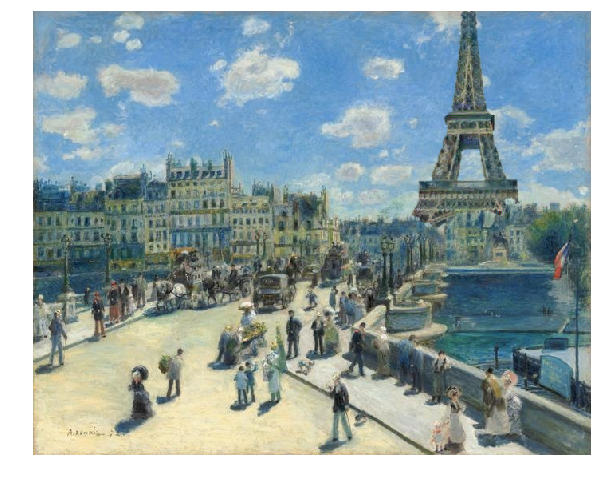

In [85]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
out_img = val_tfms.denorm(to_np(opt_img_v.data)[0].transpose(1,2,0))
out_img = out_img * mask_smth + style_img * (1-mask_smth)
out_img = out_img.clip(0,1)
ax.imshow(out_img)
ax.axis('off')

(-0.5, 699.5, 556.5, -0.5)

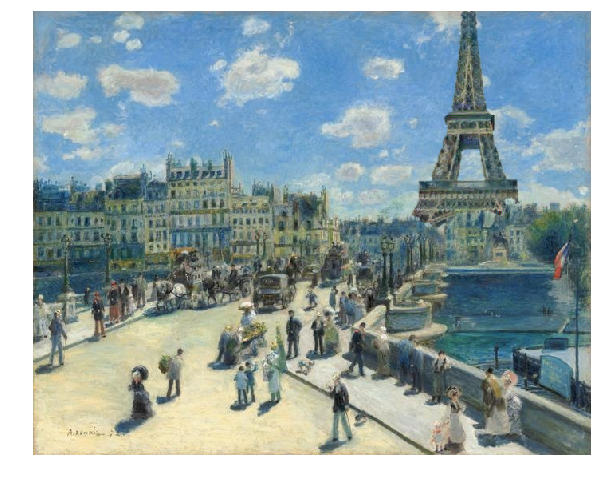

In [86]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
out_img = val_tfms.denorm(to_np(opt_img_v.data)[0].transpose(1,2,0))
out_img = out_img * mask_smth + style_img * (1-mask_smth)
out_img = out_img.clip(0,1)
ax.imshow(out_img)
ax.axis('off')